# Setting

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

## 데이터 불러오기

In [2]:
# 데이터 불러오기
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

print(iris_df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [3]:
print(iris_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB
None


# 데이터 분포 확인

In [4]:
# 컬럼명에서 '(cm)' 제거
iris_df.columns = iris_df.columns.str.replace(' (cm)', '')

In [5]:
print(iris_df.describe())

       sepal length  sepal width  petal length  petal width      target
count    150.000000   150.000000    150.000000   150.000000  150.000000
mean       5.843333     3.057333      3.758000     1.199333    1.000000
std        0.828066     0.435866      1.765298     0.762238    0.819232
min        4.300000     2.000000      1.000000     0.100000    0.000000
25%        5.100000     2.800000      1.600000     0.300000    0.000000
50%        5.800000     3.000000      4.350000     1.300000    1.000000
75%        6.400000     3.300000      5.100000     1.800000    2.000000
max        7.900000     4.400000      6.900000     2.500000    2.000000


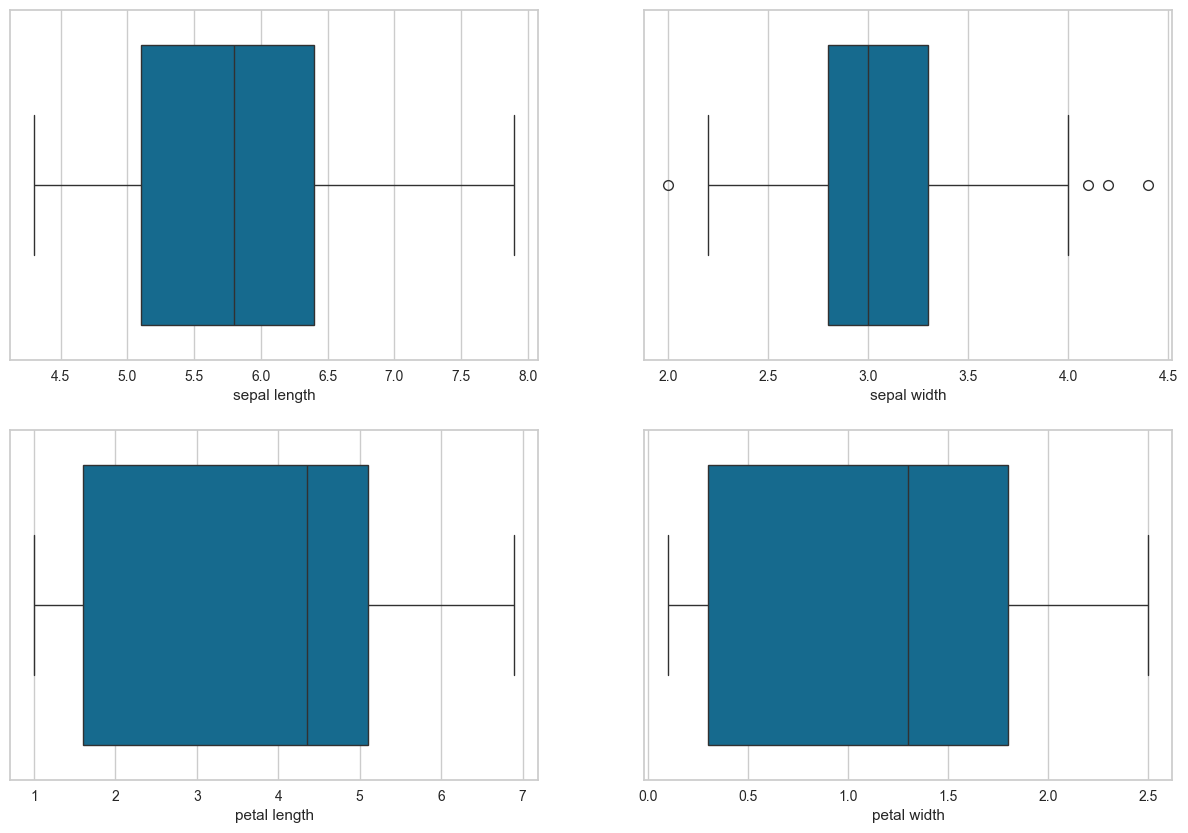

In [6]:
# 박스 플랏 확인
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='sepal length', data=iris_df)

plt.subplot(2, 2, 2)
sns.boxplot(x='sepal width', data=iris_df)

plt.subplot(2, 2, 3)
sns.boxplot(x='petal length', data=iris_df)

plt.subplot(2, 2, 4)
sns.boxplot(x='petal width', data=iris_df)

plt.show()

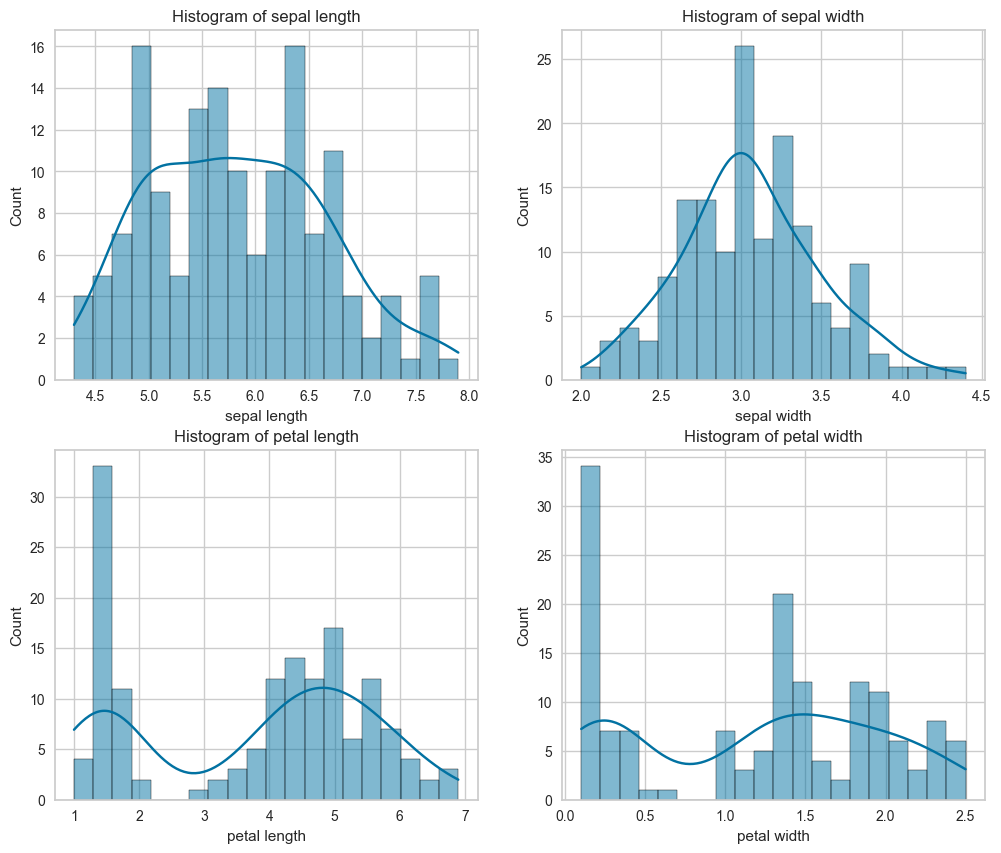

In [7]:
# 히스토그램
selected_features = ['sepal length', 'sepal width', 'petal length', 'petal width']

plt.figure(figsize=(12, 10))

for i, feature in enumerate(selected_features, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(iris_df[feature], bins=20, kde=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    
plt.show()

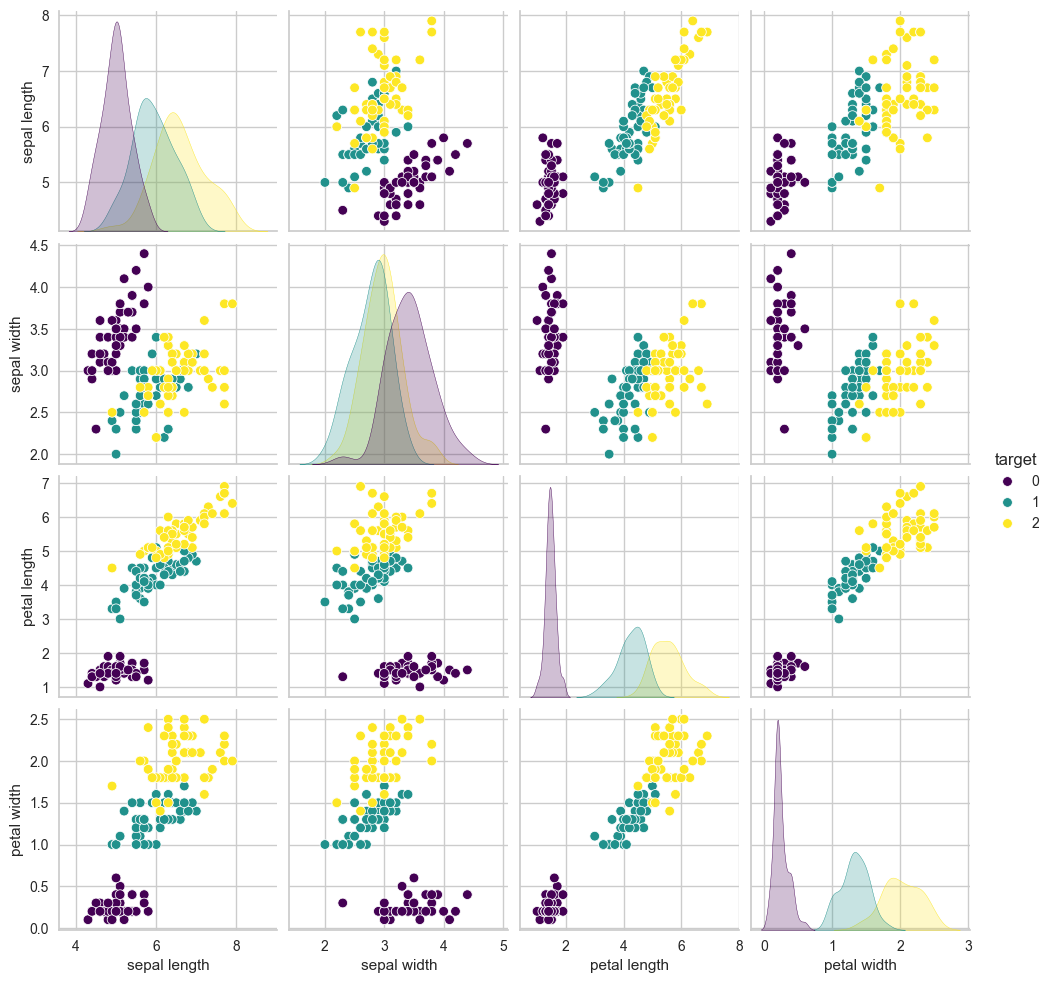

In [8]:
# pairplot
sns.pairplot(iris_df, hue='target', palette='viridis')
plt.show()

전체적으로 종에 따라 값이 다르게 분포되어있는 것으로 보이긴 하나  
sepal width의 차이가 적은 것으로 판단되고, petal length와 petal width의 차이가 큰 것으로 판단됨  

1차적으로는 4개의 변수를 모두 활용하여 군집을 나누어보고, 필요시 sepal width를 제외한 3개, 또는 petal length와 petal width 2가지의 변수를 활용하여 군집을 나누어보는 것으로 함

In [9]:
# 군집 분석에 필요한 컬럼 추출
X = iris_df[['sepal length', 'sepal width', 'petal length', 'petal width']]

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Elbow Method를 통한 k값 결정

군집 분석은 몇 개의 군집으로 나눌 것인지 임의로 결정해주어야 하여 데이터에 대한 이해와 도메인에 대한 지식이 필요함

Elbow Method : 최적의 군집 개수를 찾는 방법  
distortion score가 꺽이는 구간(팔꿈치, Elbow)가 최적의 군집 개수 - 꺽이는 구간에 대한 주관적인 견해가 들어갈 수 있음  
distortion score는 SSE(오차제곱합)  

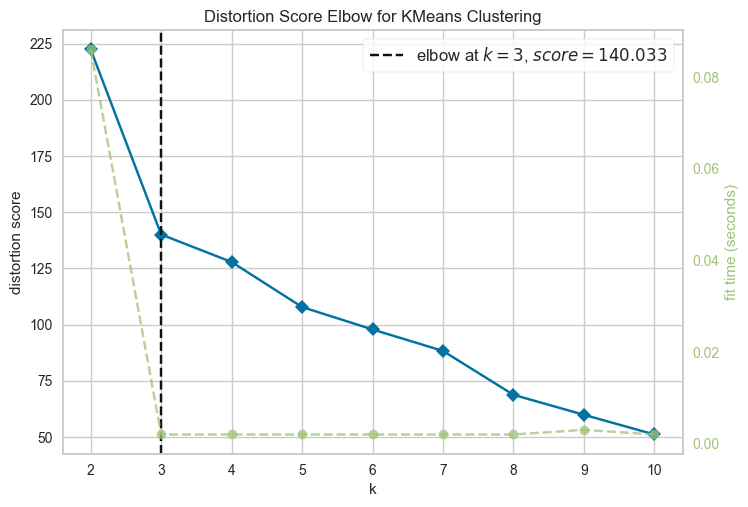

Optimal number of clusters (k): 3


In [10]:
# seed = 33, k = (2,11)
kmeans_default = KMeans(random_state=33)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 11))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

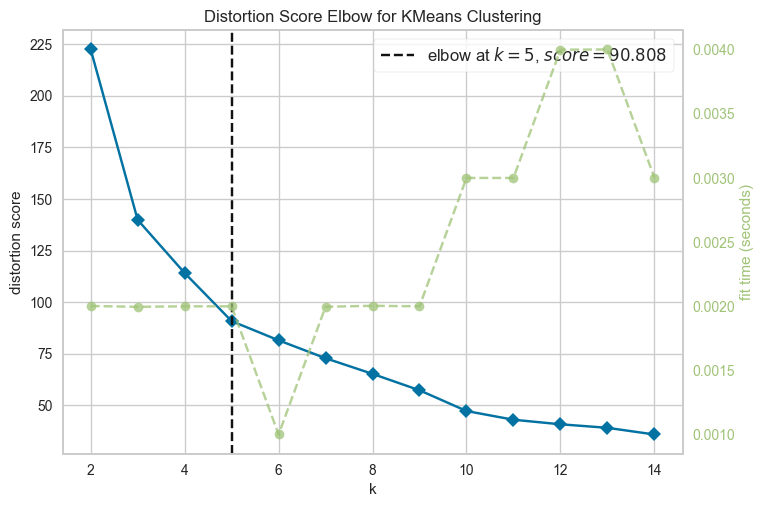

Optimal number of clusters (k): 5


In [11]:
# seed = 0, k = (2,15)
kmeans_default = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 15))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

시드와 k의 범위에 따라 optimal_k값이 변하여 주관적인 판단이 필요함  
3에서 꺾이는 정도가 가장 크다고 판단되며, 데이터의 실제 target 종류도 3종류이기 때문에 k를 3으로 결정함

## Model

In [12]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=0)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

## 실루엣 계수

개별 데이터가 할당된 군집 내 데이터와 얼마나 가깝게 군집화 되어있는지,   
다른 군집에 있는 데이터와는 얼마나 멀리 분리되어 있는지  
즉 얼마나 군집이 잘 되었는지 확인할 수 있는 값  

-1부터 1까지의 값을 가지며 1에 가까울수록 최적화된 군집임  
일반적으로 0.5 이상 : 좋음, 0.7 이상 : 매우 좋음  

In [13]:
# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.45994823920518635


0.46로 조금 낮은 실루엣 스코어를 보임

## 시드 탐색

In [14]:
best_seed = None
best_score = -1

# 시드를 0부터 99까지 변화시키면서 반복 수행
for seed in range(100):
    kmeans = KMeans(n_clusters=3, random_state=seed)
    kmeans.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    
    # 현재 시드에 대한 실루엣 스코어가 더 높으면 기록
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_seed = seed

# 가장 좋은 시드 출력
print("Best seed:", best_seed)
print("Best silhouette score:", best_score)

Best seed: 9
Best silhouette score: 0.4798814508199817


In [15]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=best_seed)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

# 파일 저장
iris_df.to_csv('kmeans_iris_4value.csv', encoding='utf-8-sig',index=False)

# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.4798814508199817


실루엣 스코어를 약 0.48로 보완함

---

# 변수 조정

일반적으로 0.5 이상의 실루엣 스코어를 좋다고 평가하므로 군집 결과가 약간 아쉽다고 판단됨   
Pari Plot에서 확인했던 정보를 토대로 변수를 조정해봄

# sepal width를 제외하고 3개 변수를 사용한 경우

In [16]:
# 군집 분석에 필요한 컬럼 추출
X = iris_df[['sepal length', 'petal length', 'petal width']]

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

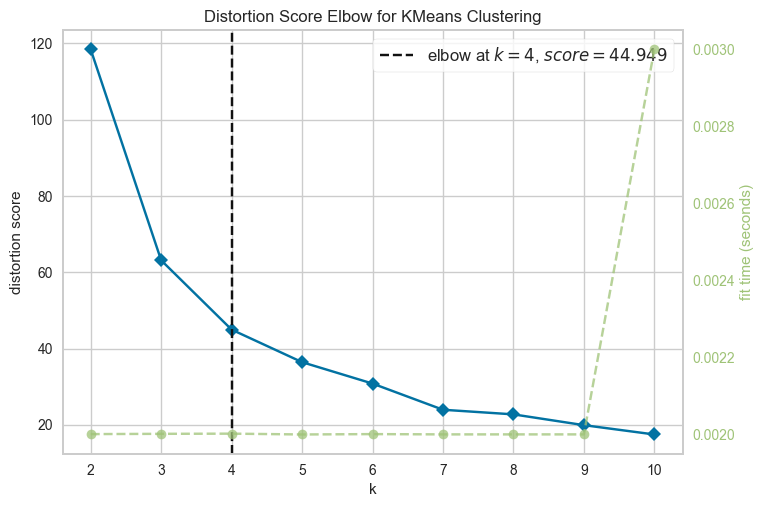

Optimal number of clusters (k): 4


In [17]:
# seed = 33, k = (2,11)
kmeans_default = KMeans(random_state=33)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 11))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

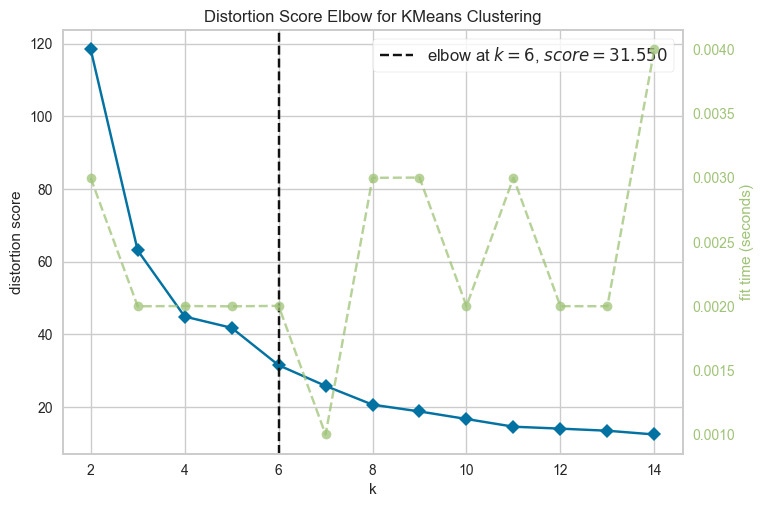

Optimal number of clusters (k): 6


In [18]:
# seed = 0, k = (2,15)
kmeans_default = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 15))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

적절한 k값은 4와 6으로 나타났지만 그래프에서 k가 3일때 많이 꺾이는 것으로 보이며, 데이터의 실제 target 종류도 3종류이기 때문에 k는 3으로 그대로 두고 진행함

In [19]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=0)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

In [20]:
# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.5390464294701763


In [21]:
best_seed = None
best_score = -1

# 시드를 0부터 99까지 변화시키면서 반복 수행
for seed in range(100):
    kmeans = KMeans(n_clusters=3, random_state=seed)
    kmeans.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    
    # 현재 시드에 대한 실루엣 스코어가 더 높으면 기록
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_seed = seed

# 가장 좋은 시드 출력
print("Best seed:", best_seed)
print("Best silhouette score:", best_score)

Best seed: 20
Best silhouette score: 0.540517187549162


In [22]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=best_seed)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

# 파일 저장
iris_df.to_csv('kmeans_iris_3value.csv', encoding='utf-8-sig',index=False)

# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.540517187549162


4개 변수를 사용했을 때는 0.48이었으나 sepal width를 제외하였더니 실루엣 스코어가 상승함

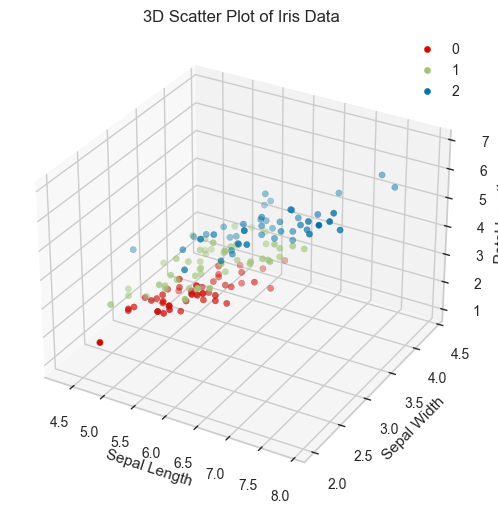

In [36]:
# 3D 산점도 그리기
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# 각 클래스별 데이터를 나누어 산점도 그리기
colors = ['r', 'g', 'b']
for i in range(3):
    class_data = iris_df[iris_df['target'] == i]
    ax.scatter(class_data['sepal length'], class_data['sepal width'], class_data['petal length'],
               c=colors[i], label=f'{i}')

ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title('3D Scatter Plot of Iris Data')
ax.legend()
plt.show()

---

# petal length와 petal width만 변수로 사용

In [23]:
# 군집 분석에 필요한 컬럼 추출
X = iris_df[['petal length', 'petal width']]

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

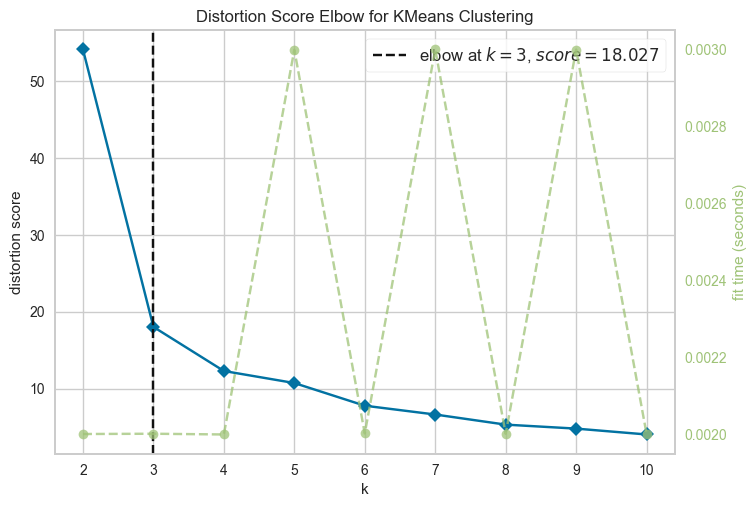

Optimal number of clusters (k): 3


In [24]:
# seed = 33, k = (2,11)
kmeans_default = KMeans(random_state=33)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 11))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

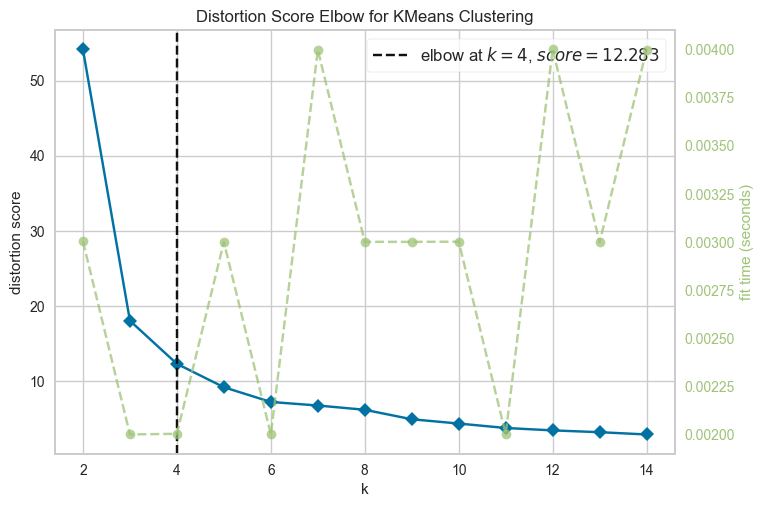

Optimal number of clusters (k): 4


In [25]:
# seed = 0, k = (2,15)
kmeans_default = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans_default, k=(2, 15))
visualizer.fit(X_scaled)
visualizer.show()
optimal_k = visualizer.elbow_value_
print("Optimal number of clusters (k):", optimal_k)

적절한 k값은 3과 4로 나타났으며, 데이터의 실제 target 종류도 3종류이기 때문에 k는 3으로 그대로 두고 진행함

In [26]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=0)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

In [27]:
# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.6741313114151009


In [28]:
best_seed = None
best_score = -1

# 시드를 0부터 99까지 변화시키면서 반복 수행
for seed in range(100):
    kmeans = KMeans(n_clusters=3, random_state=seed)
    kmeans.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    
    # 현재 시드에 대한 실루엣 스코어가 더 높으면 기록
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_seed = seed

# 가장 좋은 시드 출력
print("Best seed:", best_seed)
print("Best silhouette score:", best_score)

Best seed: 0
Best silhouette score: 0.6741313114151009


In [29]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters = 3, random_state=best_seed)
kmeans.fit(X_scaled)

# 군집 결과를 데이터프레임에 추가
iris_df['cluster'] = kmeans.labels_

# 파일 저장
iris_df.to_csv('kmeans_iris_2value.csv', encoding='utf-8-sig',index=False)

# 실루엣 스코어 확인
silhouette_avg = silhouette_score(X_scaled, iris_df['cluster'])
print("평균 실루엣 스코어:", silhouette_avg)

평균 실루엣 스코어: 0.6741313114151009


petal length와 petal width 2개 변수를 사용했을 때 실루엣 스코어가 크게 상승하였음

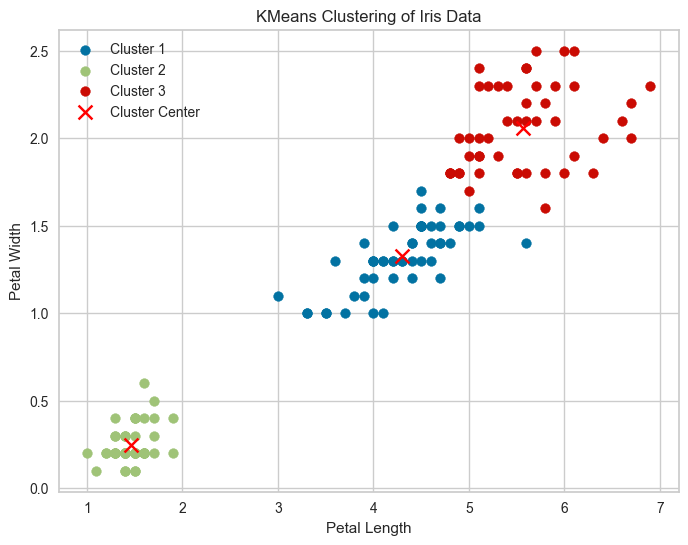

In [30]:
# 군집 중심 좌표
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# 산점도 그리기
plt.figure(figsize=(8, 6))

# 각 군집에 대해 데이터 포인트 그리기
for i in range(len(cluster_centers)):
    cluster_data = X[iris_df['cluster'] == i]
    plt.scatter(cluster_data['petal length'], cluster_data['petal width'], label=f'Cluster {i+1}')

# 군집 중심 그리기
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=100, label='Cluster Center')

plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('KMeans Clustering of Iris Data')
plt.legend()
plt.grid(True)
plt.show()